# Q2 Sparse representation and Image denoising using dictionary learning

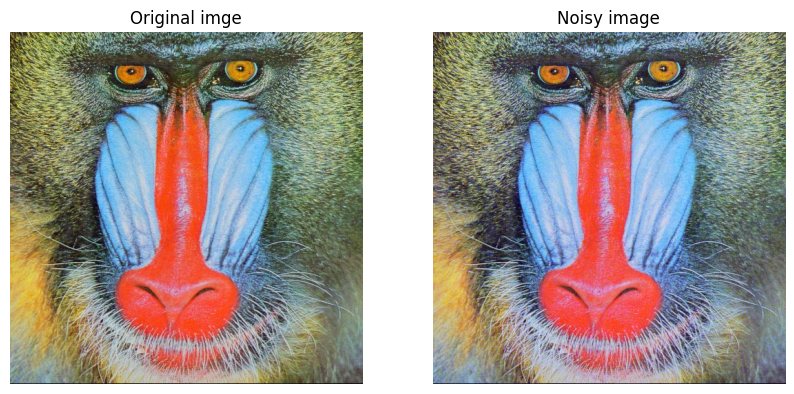

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
from time import time
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.feature_extraction.image import reconstruct_from_patches_2d


img = cv2.imread('mandrill.jpg')


mean = 0
stddev = 50
noise = np.zeros(img.shape, np.uint8)
cv2.randn(noise, mean, stddev)
noisy_img = cv2.add(img, noise)

fig = plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Original imge")


plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(noisy_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Noisy image")

img = img.astype(np.float64)
noisy_img = noisy_img.astype(np.float64)

def show_result(re_img,img, title):
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.title("Noisy Image")
    plt.imshow(img, cmap=plt.cm.gray, interpolation="nearest")
    plt.subplot(1, 2, 2)
    plt.title("Reconstructed Image")
    plt.imshow(re_img, cmap=plt.cm.gray, interpolation="nearest")


------------------------------------------ 0-th Dimension of RGB image-----------------------------------------------
Extracting reference patches...
256036 patches extracted in 0.10s.
Learning the dictionary...
1.0 iterations / 120 steps in 23.26.
Extracting noisy patches... 
done in 0.04s.
Orthogonal Matching Pursuit
2 atoms...
done in 12.98s.
Least-angle regression
2 atoms...
done in 62.02s.


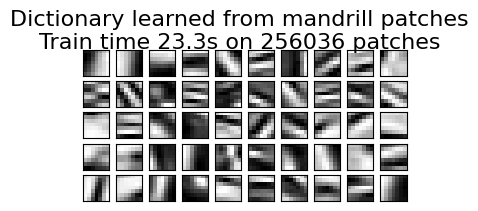

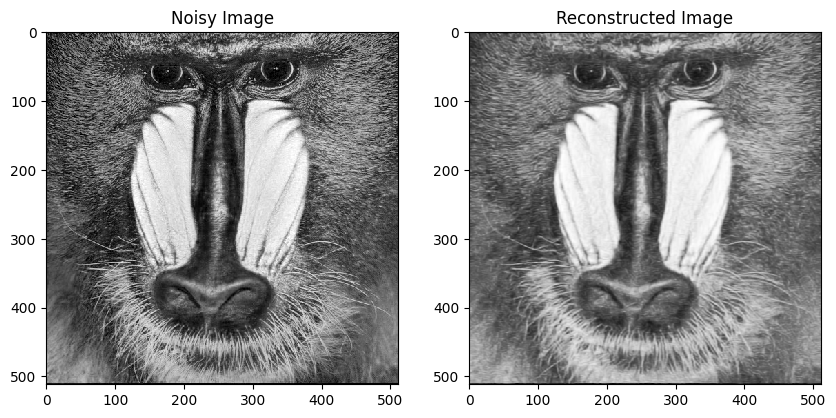

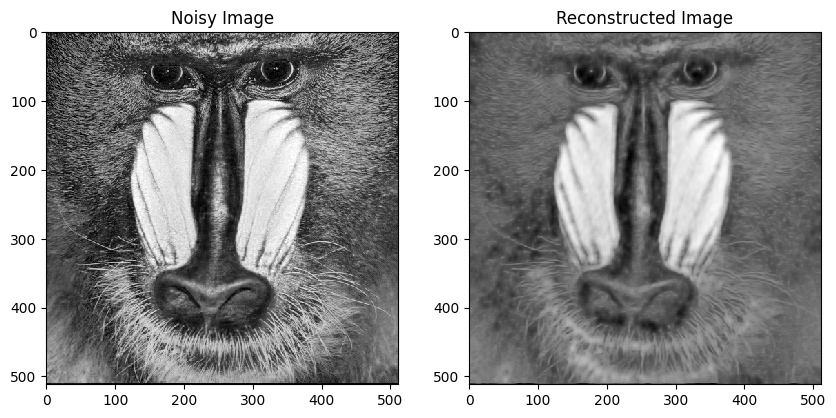

------------------------------------------ 1-th Dimension of RGB image-----------------------------------------------
Extracting reference patches...
256036 patches extracted in 0.11s.
Learning the dictionary...
1.0 iterations / 113 steps in 23.41.
Extracting noisy patches... 
done in 0.04s.
Orthogonal Matching Pursuit
2 atoms...
done in 13.48s.
Least-angle regression
2 atoms...
done in 62.75s.


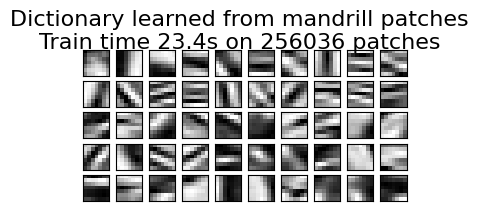

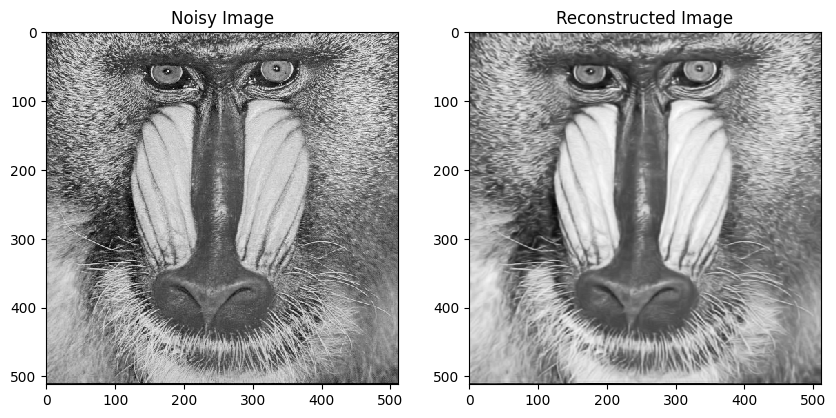

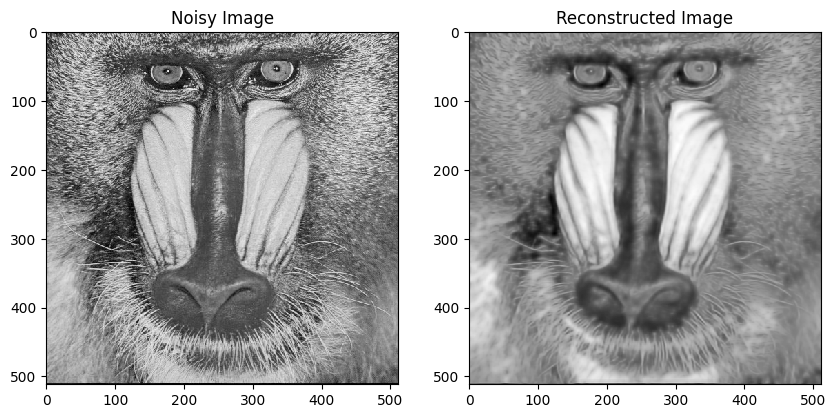

------------------------------------------ 2-th Dimension of RGB image-----------------------------------------------
Extracting reference patches...
256036 patches extracted in 0.12s.
Learning the dictionary...
1.0 iterations / 127 steps in 24.21.
Extracting noisy patches... 
done in 0.04s.
Orthogonal Matching Pursuit
2 atoms...
done in 12.62s.
Least-angle regression
2 atoms...
done in 61.62s.


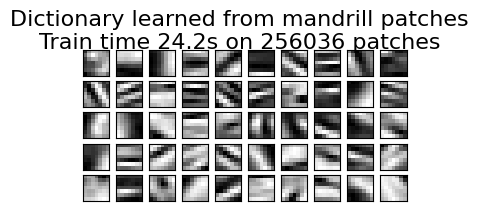

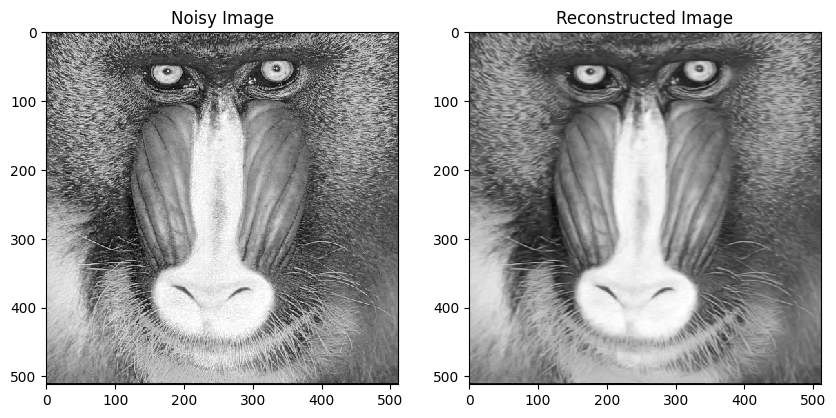

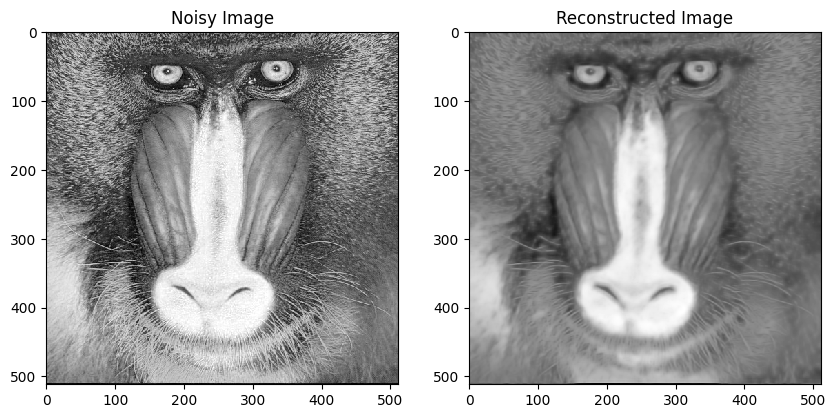

In [4]:
re_img_LAR = np.zeros_like(img)
re_img_OMP = np.zeros_like(img)
for d in range(3):
  print("------------------------------------------ {}-th Dimension of RGB image-----------------------------------------------".format(d))
  I = img[:,:,d]
  nI = noisy_img[:,:,d]
  # Extract all reference patches from the image
  print("Extracting reference patches...")
  t0 = time()
  patch_size = (7, 7)
  data = extract_patches_2d(I, patch_size)
  data = data.reshape(data.shape[0], -1)
  data -= np.mean(data, axis=0)
  data /= np.std(data, axis=0)
  print(f"{data.shape[0]} patches extracted in %.2fs." % (time() - t0))

  print("Learning the dictionary...")
  t0 = time()
  dico = MiniBatchDictionaryLearning(n_components=50,batch_size=200,alpha=1.0,max_iter=10,)
  V = dico.fit(data).components_
  dt = time() - t0
  print(f"{dico.n_iter_} iterations / {dico.n_steps_} steps in {dt:.2f}.")
  plt.figure(figsize=(4.2, 4))

  for i, comp in enumerate(V[:100]):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape(patch_size), cmap=plt.cm.gray_r, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())
  plt.suptitle( "Dictionary learned from mandrill patches\n" + "Train time %.1fs on %d patches" % (dt, len(data)), fontsize=16,)


  print("Extracting noisy patches... ")
  t0 = time()
  data = extract_patches_2d(nI, patch_size)
  data = data.reshape(data.shape[0], -1)
  intercept = np.mean(data, axis=0)
  data -= intercept
  print("done in %.2fs." % (time() - t0))
  transform_algorithms = [
    ("Orthogonal Matching Pursuit\n2 atoms", "omp", {"transform_n_nonzero_coefs": 2}),
    ("Least-angle regression\n2 atoms", "lars", {"transform_n_nonzero_coefs": 2}),]
  reconstructions = {}
  for title, transform_algorithm, kwargs in transform_algorithms:
    print(title + "...")
    reconstructions[title] = I.copy()
    t0 = time()
    dico.set_params(transform_algorithm=transform_algorithm, **kwargs)
    code = dico.transform(data)
    patches = np.dot(code, V)

    patches += intercept
    patches = patches.reshape(len(data), *patch_size)
    if transform_algorithm == "threshold":
        patches -= patches.min()
        patches /= patches.max()
    reconstructions[title] = reconstruct_from_patches_2d(patches, I.shape)
    dt = time() - t0
    print("done in %.2fs." % dt)
    show_result(reconstructions[title], I, title + " (time: %.1fs)" % dt)
    if transform_algorithm=="omp":
      re_img_OMP[:,:,d] = reconstructions[title]
    elif transform_algorithm=="lars":
      re_img_LAR[:,:,d] = reconstructions[title]
  plt.show()

--------------------------------Noisy Image-----------------------------------------


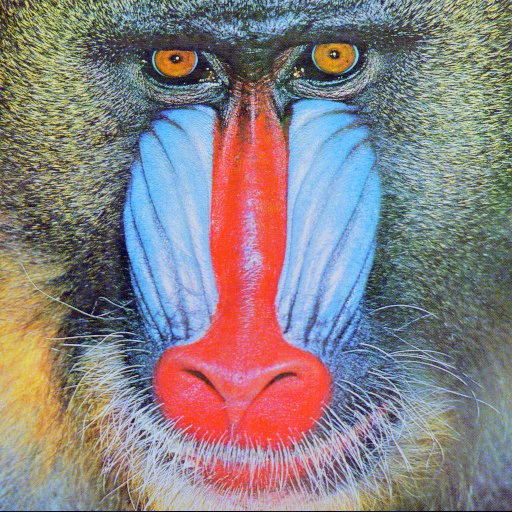

-----------------Reconstructed Image form Orthogonal Matching Pursuit---------------


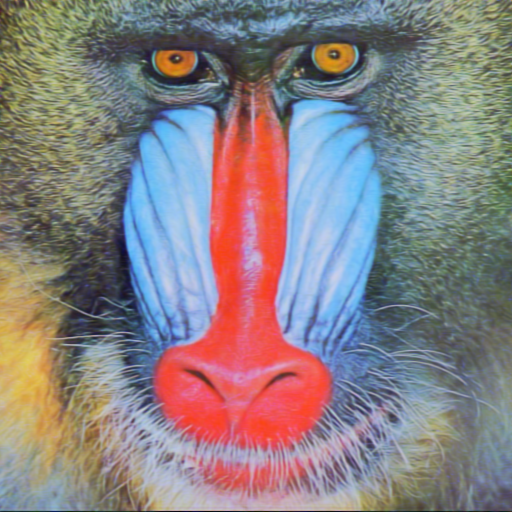

------------------Reconstructed Image form Least Angle Regression-------------------


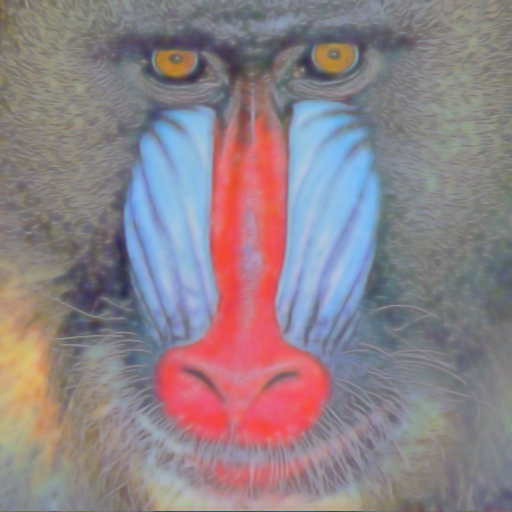

In [5]:
print("--------------------------------Noisy Image-----------------------------------------")
cv2_imshow(noisy_img)

print("-----------------Reconstructed Image form Orthogonal Matching Pursuit---------------")
cv2_imshow(re_img_OMP)

print("------------------Reconstructed Image form Least Angle Regression-------------------")
cv2_imshow(re_img_LAR)


In [6]:
def psnr(im1, im2): # PSNR function for 0-255 values
    mse = ((im1 - im2) ** 2).mean()
    psnr = 10 * np.log10(255 ** 2 / mse)
    return psnr

print("psnr of reconstructed image using OMP algorithm: ", psnr(noisy_img, re_img_OMP))
print("psnr of reconstructed image using LAR algorithm: ", psnr(noisy_img, re_img_LAR))

psnr of reconstructed image using OMP algorithm:  21.77042831740932
psnr of reconstructed image using LAR algorithm:  17.9485114056548
